<a href="https://colab.research.google.com/github/dimidagd/gists/blob/main/Check_for_grad_mix_across_batchipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple model for demonstration
class SimpleModel(nn.Module):
    def __init__(self, input_size=(1, 50, 50), num_classes=5):
        super(SimpleModel, self).__init__()
        self.num_classes = num_classes
        self.conv = nn.Conv2d(1, 10, kernel_size=5)
        self.bn = nn.InstanceNorm2d(10)

        # Dynamically calculate the flattened feature size
        self.flatten_size = self._get_conv_output(input_size)

        self.fc = nn.Linear(self.flatten_size, num_classes)
        self.ln = nn.LayerNorm(self.flatten_size)

        # Freeze the fully connected layer
        self.freeze_layer(self.fc)

    def save_grad(self, grad):
        self.grad = grad

    def get_grad(self):
        return self.grad

    def forward(self, x):
        x = F.relu(self.conv(x))
        x.register_hook(self.save_grad)
        x = self.bn(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.ln(x)
        x = self.fc(x)
        return x

    def _get_conv_output(self, input_size):
        """
        Dynamically computes the size of the flattened feature map after the convolution layers.
        :param input_size: tuple (channels, height, width) of the input image.
        :return: Flattened size after convolutions.
        """
        # Create a dummy input tensor with the input size
        dummy_input = torch.zeros(1, *input_size)

        # Pass through conv and batch norm layers to determine the output size
        output = self.conv(dummy_input)
        output = self.bn(output)

        # Flatten the output to get the total number of features
        return output.view(1, -1).size(1)

    @staticmethod
    def freeze_layer(layer):
        for param in layer.parameters():
            param.requires_grad = False

In [184]:
model = SimpleModel()
model.zero_grad()
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [185]:
model.fc.weight

Parameter containing:
tensor([[ 0.0024, -0.0063,  0.0032,  ..., -0.0051, -0.0062, -0.0010],
        [-0.0002,  0.0033,  0.0002,  ...,  0.0067, -0.0057,  0.0007],
        [ 0.0035,  0.0045,  0.0038,  ...,  0.0052, -0.0016, -0.0063],
        [ 0.0005, -0.0056,  0.0043,  ..., -0.0006, -0.0014,  0.0026],
        [ 0.0063, -0.0015,  0.0017,  ...,  0.0038, -0.0039,  0.0019]])

grad of parameter x wrt class 0 shape: torch.Size([1, 10, 46, 46])
grad sum val of parameter x wrt class 0: -3.0517578125e-05
grad of parameter x wrt class 1 shape: torch.Size([1, 10, 46, 46])
grad sum val of parameter x wrt class 1: 7.152557373046875e-05
grad of parameter x wrt class 2 shape: torch.Size([1, 10, 46, 46])
grad sum val of parameter x wrt class 2: 1.71661376953125e-05
grad of parameter x wrt class 3 shape: torch.Size([1, 10, 46, 46])
grad sum val of parameter x wrt class 3: 5.340576171875e-05
grad of parameter x wrt class 4 shape: torch.Size([1, 10, 46, 46])
grad sum val of parameter x wrt class 4: 3.814697265625e-06


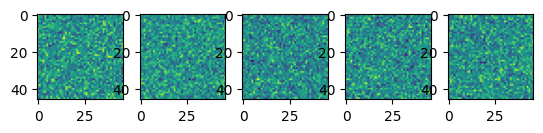

In [189]:
# Get a parameter's gradient wrt to an output value in the classification head
# 1) Notice .register_hook in the model's forward pass.
# 2) The gradients should be different wrt to every value in the output tensor (for a fixed batch index)
# 3) If retain_graph is used in the .backwward() call, then there is no need to repeat the forward pass, or zero out the gradients. One can simply repeat the backward pass, but wrt to another element in the output vector y.
from matplotlib import pyplot as plt
torch.manual_seed(0)
X = torch.rand(1,1,50,50,requires_grad=True)
gradients_wrt_to_class = []
model.zero_grad()
y = model(X)
batch_idx = 0
for class_idx in range(model.num_classes):
  y[batch_idx,class_idx].backward(retain_graph=True)
  print(f"grad of parameter x wrt class {class_idx} shape: {model.get_grad().shape}")
  print(f"grad sum val of parameter x wrt class {class_idx}: {model.get_grad().sum()}")
  gradients_wrt_to_class.append(model.get_grad().detach())
f,axs = plt.subplots(1, len(gradients_wrt_to_class))
for ax, grad in zip(axs, gradients_wrt_to_class):
  ax.imshow(grad[0].mean(dim=0))

In [190]:
# If no batch norm is used, then when calculating the grads with respect to the i element in the batch, the gradients on the other indexes should be zero.
# Also, since layers are frozen the parameters should not be updated.

n_batch = 5
for i in range(n_batch):
  X = torch.rand(n_batch,1,50,50,requires_grad=True)
  loss = model(X)
  sample_loss = loss[i]
  sample_loss.sum().backward()
  with torch.no_grad():
    grads = [sample_grad.abs().sum().item() for sample_grad in X.grad]
    print("gradients are",grads)
    grads.pop(i)
    #assert not any(grads)
    old_weights = model.fc.weight.clone().detach()
    optimizer.step()
    new_weights = model.fc.weight.clone().detach()
    print("Difference in layer weights",(old_weights-new_weights).sum())
    model.zero_grad()

gradients are [247.12770080566406, 0.0, 0.0, 0.0, 0.0]
Difference in layer weights tensor(0.)
gradients are [0.0, 234.8011474609375, 0.0, 0.0, 0.0]
Difference in layer weights tensor(0.)
gradients are [0.0, 0.0, 231.72422790527344, 0.0, 0.0]
Difference in layer weights tensor(0.)
gradients are [0.0, 0.0, 0.0, 225.580322265625, 0.0]
Difference in layer weights tensor(0.)
gradients are [0.0, 0.0, 0.0, 0.0, 228.7405242919922]
Difference in layer weights tensor(0.)
